In [12]:
# IMPORTS
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy.ndimage import convolve
import cv2
import nibabel as nib
from sklearn.cluster import KMeans, DBSCAN

La première partie du travail consiste en l'application de méthodes de traitement d'image afin d'améliorer la qualité des images. Pour ce faire, nous utilisons des fichiers dicoms que l'on va traiter en Numpy arrays. En ce qui concerne l'implémentation des fonctions, nous avons essayé de toutes les implémenter nous-mêmes. Cependant, ceci n'étant pas toujours très efficace, nous préférons utiliser des méthodes toutes faites fournies par les librairies Python. L'ensemble de ces fonctions demandent un Numpy array en input, c'est-à-dire un array de pixels. 

Globalement, pour améliorer la qualité des images, nous avons appliqué un linear strech, une égalisation ainsi que l'algorithme CLAHE.

In [13]:
#Retourne l'histogramme normalisé de l'array 
#En normalisant l'histogramme, nous le trouvions plus lisible
def histogram(arr):
    maxValue = np.max(arr)
    h,w = arr.shape
    n = h*w
    histogram = np.array([0]*(maxValue+1))
    for i in arr:
        for j in i:
            histogram[j] += 1
    histogram_n = histogram/n#histogramme normalisé
    return histogram_n

#Retourne l'histogramme cumulé de l'array
def cumulative(arr):
    maxValue = np.max(arr)
    cumul = np.zeros((maxValue))
    histo = histogram(arr)
    for i in range(len(cumul)):
        cumul[i] = np.sum(histo[0:i+1])
    return cumul
# This function is transforming an image with the Transform vector --> Je sais pas ce que fait cette fonction
def Transformation(image, transform):
    newArr = copy.deepcopy(image)
    for i in range(len(image)):
        for j in range(len(image[i])):
            newArr[i, j] = transform[image[i, j]]
    return newArr  

#Réalise une interpolation linéaire pour le linear strech de l'histogramme
#Dans notre cas, les images sont de taille 260x320 et sont encodées sur 345 valeurs. Nous souhaitons faire une interpolation
#sur 256 valeurs et donc, nous réalisons une compression et non pas une élongation de l'histogramme.
def crimping(arr):
    maxValue = np.max(arr)
    histo = histogram(arr)
    Transform = np.arange(0,  maxValue + 1)
    deltaA = (maxValue - np.min(np.where(histo > 0)))/(255)
    Transform = np.ceil(Transform / deltaA)   
    newArr = Transformation(arr, Transform)
    return newArr

#Réalise une égalisation de l'histogramme de facon à ce qu'il n'y ait pas une valeur de pixel qui soit plus utilisée
def equalize(arr):
    h,w = arr.shape
    n = h*w
    C = ((344-1)/n)
    new_arr = np.zeros((h,w),dtype=int)
    histo = histogram(arr)*n
    for i in range(h):
        for j in range(w):
            value = arr[i,j]
            new_arr[i,j] = C*(np.sum(histo[0:value+1]))
    return new_arr

#Notre implémentation de CLAHE: pour mémoire car il prend trop de temps
#cet algorithme consiste à appliquer une égalisation d'histogramme sur des blocs de pixels de taille 8x8 (en général). 
#Il permet donc de ne pas amplifier le bruit.
def Clahe(arr):
    h,w = arr.shape
    new_arr = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            C = arr[i:i+7,j:j+7]
            new_C = equalize(C)
            new_arr[i:i+7,j:j+7] = new_C
            if (j+7 >= w):
                break
            else:
                j = j+7
        if(i+7>=h):
            break
        else:
            i = i+7
    plt.imshow(new_arr, cmap='Greys')

#Implémentation de python
def clahe(arr):
    clahe = cv2.createCLAHE()
    cl1 = clahe.apply(arr)
    return cl1

Nous allons maintenant afficher les résultats obtenus sur une même image mais avec les différentes méthodes.

Text(0.5, 1.0, 'Histogramme de l image traitée avec CLAHE')

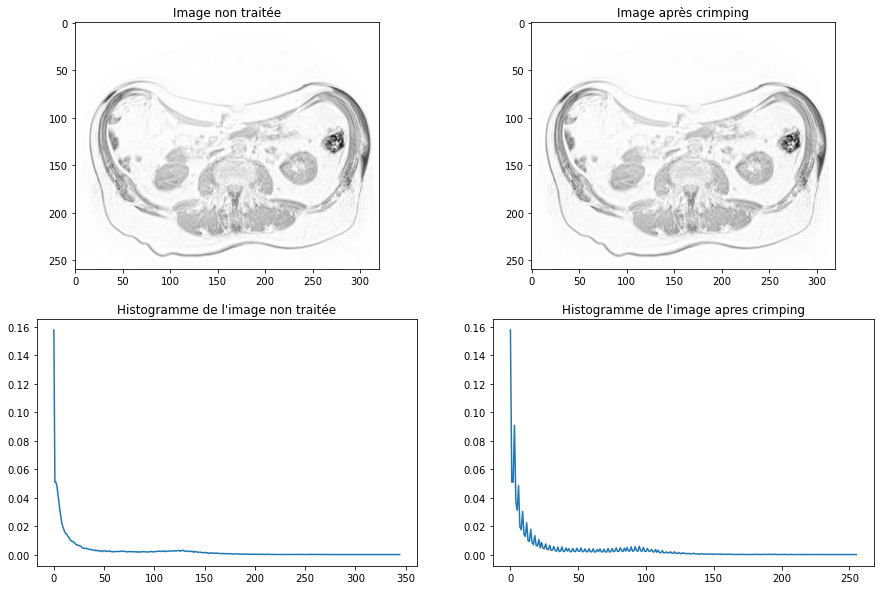

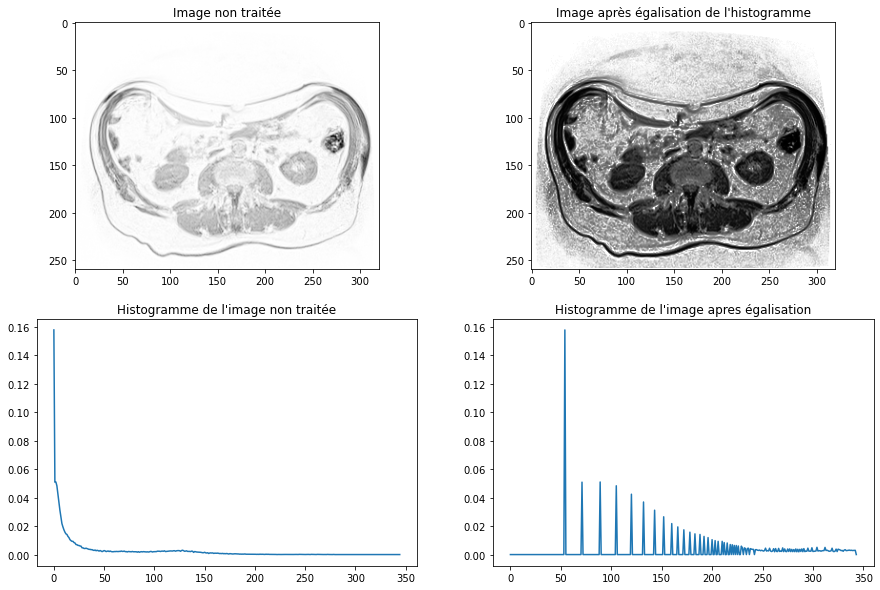

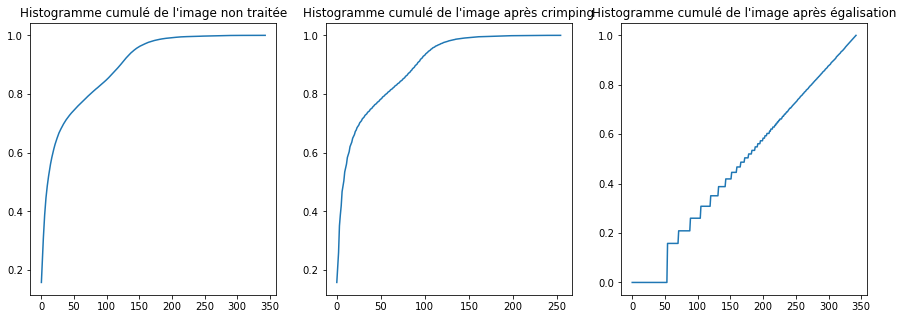

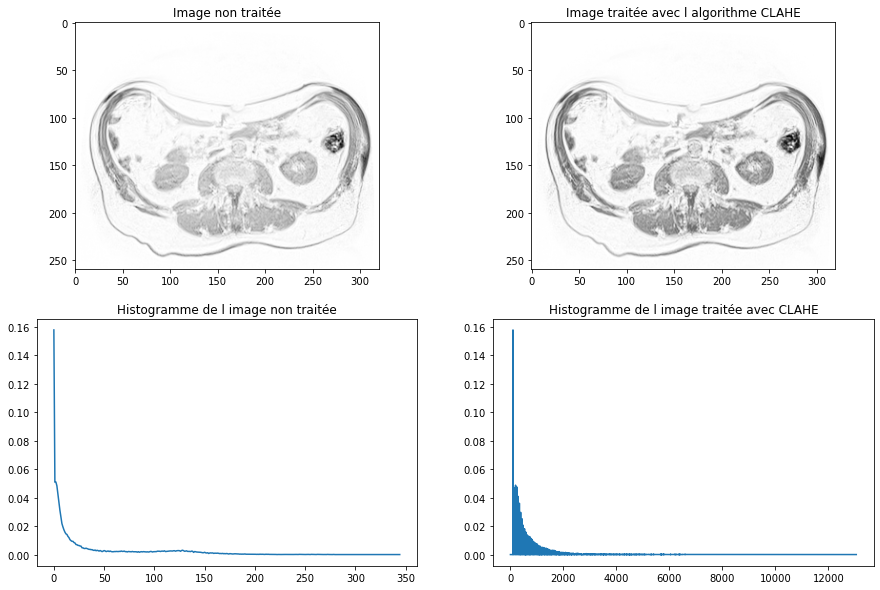

In [14]:
#Lecture d'un fichier dicom
ds = pydicom.read_file("data/IM-0001-0001-0001.dcm")
arr = ds.pixel_array

#calcul des variables utiles
arr_crimp = crimping(arr)
histo = histogram(arr)#histogramme de l image non traitee
histogram_lin = histogram(arr_crimp)#histogramme de l image apres crimping

arr_egal = equalize(arr)
histogram_egal = histogram(arr_egal)#histogramme de l image apres égalisation

cl1 = clahe(arr)
histo = histogram(arr)#histogramme de l image non traitee
histo_cl1 = histogram(cl1)#histogramme après CLAHE

cumul = cumulative(arr)
cumul_lin = cumulative(arr_crimp)
cumul_egal = cumulative(arr_egal)

#plot des figures relatives au crimping
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.imshow(arr, cmap='Greys')
plt.title('Image non traitée')

plt.subplot(2,2,2)
plt.imshow(arr_crimp,cmap='Greys')
plt.title('Image après crimping')

plt.subplot(2,2,3)
plt.plot(histo)
plt.title('Histogramme de l\'image non traitée')

plt.subplot(2,2,4)
plt.plot(histogram_lin)
plt.title('Histogramme de l\'image apres crimping')

#plot des figures relatives à l'égalisation des histogrammes
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(arr, cmap='Greys')
plt.title('Image non traitée')

plt.subplot(2,2,2)
plt.imshow(arr_egal,cmap='Greys')
plt.title('Image après égalisation de l\'histogramme')

plt.subplot(2,2,3)
plt.plot(histo)
plt.title('Histogramme de l\'image non traitée')

plt.subplot(2,2,4)
plt.plot(histogram_egal)
plt.title('Histogramme de l\'image apres égalisation')

#plot des figures relatives aux histogrammes cumulés
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(cumul)
plt.title('Histogramme cumulé de l\'image non traitée')
          
plt.subplot(1,3,2)
plt.plot(cumul_lin)
plt.title('Histogramme cumulé de l\'image après crimping')

plt.subplot(1,3,3)
plt.plot(cumul_egal)
plt.title('Histogramme cumulé de l\'image après égalisation')

#Plot des résultats avec l'algorithme CLAHE
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(arr, cmap='Greys')
plt.title('Image non traitée')

plt.subplot(2,2,2)
plt.imshow(cl1, cmap='Greys')
plt.title('Image traitée avec l algorithme CLAHE')

plt.subplot(2,2,3)
plt.plot(histo)
plt.title('Histogramme de l image non traitée')

plt.subplot(2,2,4)
plt.plot(histo_cl1)
plt.title('Histogramme de l image traitée avec CLAHE')

Il faudrait peut-être commenter les images. Dire ce qu'on pense de l'utilité des différents algorithmes implémentés.

La deuxième partie de ce projet consiste en l'utilisation d'algorithme pour déterminer la localisation de la tumeur sur des images 2D. Ces algorithmes sont k-means, DBSCAN et region growing. Avant toute chose, on travaille désormais sur des fichiers Nifty et non plus sur des fichiers Dicoms car nous avons directement accès à la slice 2D. De plus, on transforme les données en input.

In [15]:
#Ouverture des nifty en tant que numpy array 
img = nib.load('Anonymized - L16223A_port__t1_vibe_dixon_tra_caipi4_bh_320_20161207155610_18.nii')
data = img.get_fdata()#pour avoir un numpy array

#Fonctions pour transformer les datas mises en input de k-means
#Transforme tout en une liste 1D de taille 320x260
#Il faut expliquer concrètement la liste 
def NewListing2D(inputImage, layer):
    #Function will return a list of X, Y, Z, grayscale number
    X = np.zeros((inputImage.shape[0]*inputImage.shape[1], 3))
    for i in range(inputImage.shape[0]):
        for j in range(data.shape[1]):
                X[j + inputImage.shape[1]*i, 0] = i
                X[j + inputImage.shape[1]*i, 1] = j
                X[j + inputImage.shape[1]*i, 2] = inputImage[i, j, layer]
    return X

def NewListing2D2D(inputImage):
    #Function will return a list of X, Y, Z, grayscale number
    X = []
    for i in range(inputImage.shape[0]):
        for j in range(inputImage.shape[1]):
            if inputImage[i, j] == 1:
                X.append([i, j])    
    return np.array(X)

def NewListing2Dwo(inputImage, layer):
    #Function will return a list of X, Y, Z, grayscale number
    X = np.zeros((inputImage.shape[0]*inputImage.shape[1], 1))
    for i in range(inputImage.shape[0]):
        for j in range(inputImage.shape[1]):
                #X[j + data.shape[1]*i, 0] = i
                #X[j + data.shape[1]*i, 1] = j
                X[j + inputImage.shape[1]*i, 0] = inputImage[i, j, layer]
    return X

Ci-dessous, nous affichons les résultats obtenus avec l'algorithme k-means pour la slice 42. Nous avons pu estimer que le nombre de cluster devait être environ de 3 ou 4.

Text(0.5, 1.0, 'K-means with 4 clusters (grayscale)')

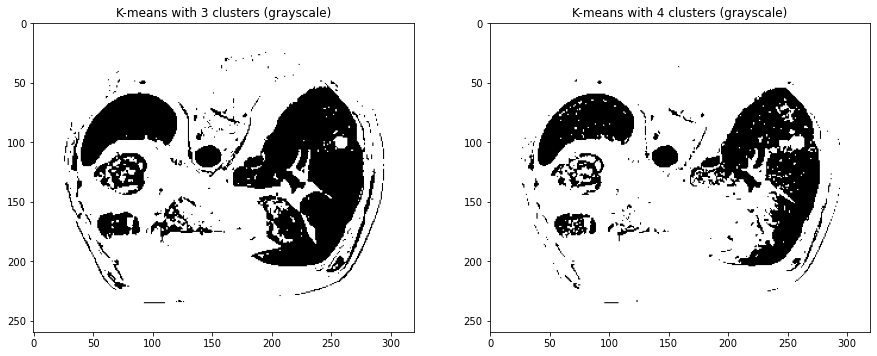

In [16]:
#On transforme l'image en une liste 1D car l'algorithme kmeans de Python fonctionne en 1D
slice_number = 42
x = NewListing2Dwo(data, slice_number)

#L'algorithme prédit le cluster pour chaque pixel
kmeans1 = KMeans(n_clusters=3).fit(x)
kmeans2 = KMeans(n_clusters=4).fit(x)
y_kmeans = kmeans1.predict(x)
y_kmeans2 = kmeans2.predict(x)

position = 100*300 + 250 #position de la tumeur --> pourrait être adapté
#on regarde le label associé a la tumeur
label = y_kmeans[position]
label2 = y_kmeans2[position]

#sur la liste de pixel, soit on associe un 1 si le pixel est associé au label de la tumeur
#soit on associe un 0 si le pixel est associé à un autre label
y_bw = (y_kmeans == label)
y_bw2 = (y_kmeans2 == label2)

#reconstruction de l'image 2D
imageOut2 = np.zeros((data.shape[0], data.shape[1]))
imageOut22 = np.zeros((data.shape[0], data.shape[1]))
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        imageOut2[i, j] = y_bw[j + data.shape[1]*i]
        imageOut22[i, j] = y_bw2[j + data.shape[1]*i]

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.imshow(imageOut2.T, cmap='Greys')
plt.title("K-means with 3 clusters (grayscale)")
plt.subplot(1, 2, 2)
plt.imshow(imageOut22.T, cmap='Greys')
plt.title("K-means with 4 clusters (grayscale)")

L'algorithme k-means permet de traiter l'entièreté d'une slice 2D et de classer chacun des pixels dans un cluster regroupant une même caractéristique. Evidemment, ici, on ne s'intéresse pas à classer les pixels. On s'intéresse à localiser la tumeur. Par conséquent, le cluster contenant la tumeur contient à la fois la tumeur mais aussi d'autres pixels ne faisant pas partie de la tumeur. Nous appliquons donc l'algorithme du DBSCAN permettant de réaliser du spectral clustering avec les plus proches voisins. L'idée de cet algorithme est à nouveau de partitionner en cluster. Plus précisément, sur base du cluster contenant la tumeur tel que fourni par l'algorithme kmeans, le partionnement est réalisé sur base de la densité dans un voisinage e. Autrement dit, en partant d'un point, l'algorithme va regarder si dans un voisinage e, il y a bien un certain nombre de pixels et ainsi de suite. 

Text(0.5, 1.0, 'Exclude de right cluster')

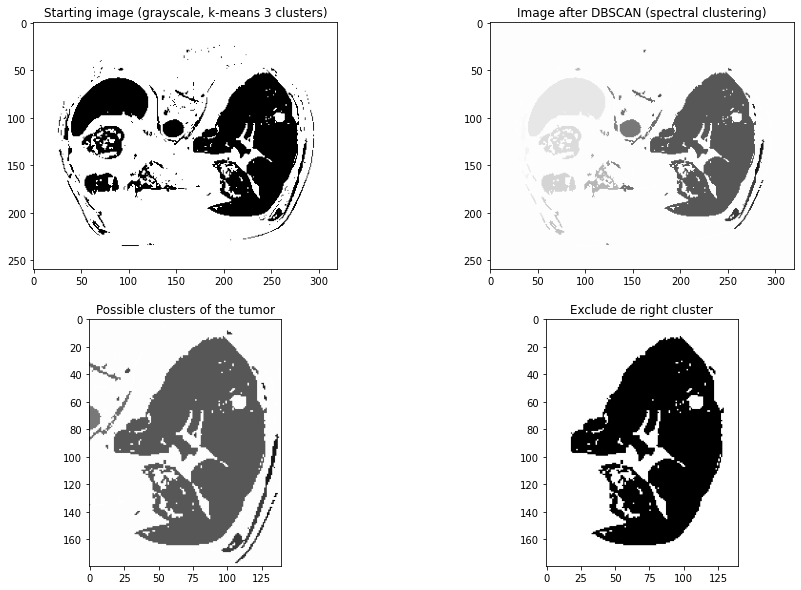

In [17]:
#Spectral clustering via la méthode du DBSCAN
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.imshow(imageOut2.T, cmap='Greys')
plt.title("Starting image (grayscale, k-means 3 clusters)")

#spectral clustering dans un voisinage de taille 1.5
X = NewListing2D2D(imageOut2)
clustering = DBSCAN(eps=1.5, min_samples=5).fit(X)
y = clustering.labels_

#reconstruction de l image 2D
imageOut3 = np.zeros((imageOut2.shape[0], imageOut2.shape[1]))
for i in range(len(y)):
    imageOut3[X[i, 0], X[i, 1]] = y[i]
    
good_cluster_DBSCAN = imageOut3[260, 135]# cluster regroupant la tumeur (il s agit d un numero)
imageOut4 = (imageOut3[150:290,40:220].T == good_cluster_DBSCAN) #on restreint l image a quelques clusters et on choisit le bon
plt.subplot(2, 2, 2)
plt.imshow(imageOut3.T, cmap='Greys')
plt.title("Image after DBSCAN (spectral clustering)")

plt.subplot(2, 2, 3)
plt.imshow(imageOut3[150:290,40:220].T, cmap='Greys')
plt.title("Possible clusters of the tumor")


plt.subplot(2, 2, 4)
plt.imshow(imageOut4, cmap='Greys')
plt.title("Exclude de right cluster")